In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from d2l import torch as d2l

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_1x1conv=False, stride=1):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        
        if use_1x1conv:
            self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        else:
            self.conv3 = None
        
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [3]:
class ResidualBlockModified(nn.Module):
    def __init__(self, in_channels, out_channels, use_1x1conv=False, stride=1):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        
        if use_1x1conv:
            self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        else:
            self.conv3 = None
        
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self, X):
        Y = self.conv1(F.relu(self.bn1(X)))
        Y = self.conv2(F.relu(self.bn2(Y)))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return Y

In [18]:
class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, use_1x1conv=False, stride=1):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, hidden_channels, kernel_size=1)
        self.conv2 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, stride=stride, padding=1)
        self.conv3 = nn.Conv2d(hidden_channels, out_channels, kernel_size=1)
        
        if use_1x1conv:
            self.conv4 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
            self.bn4 = nn.BatchNorm2d(out_channels)
        else:
            self.conv4 = None
            self.bn4 = None
            
        self.bn1 = nn.BatchNorm2d(hidden_channels)
        self.bn2 = nn.BatchNorm2d(hidden_channels)
        self.bn3 = nn.BatchNorm2d(out_channels)
        
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = F.relu(self.bn2(self.conv2(Y)))
        Y = self.bn3(self.conv3(Y))
        if self.conv4:
            X = self.bn4(self.conv4(X))
        Y += X
        return F.relu(Y)

In [4]:
blk = ResidualBlock(3, 3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [5]:
blk = ResidualBlock(3, 6, use_1x1conv=True, stride=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

In [6]:
blk = ResidualBlockModified(3, 3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [7]:
blk = ResidualBlockModified(3, 6, use_1x1conv=True, stride=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

In [19]:
blk = BottleneckBlock(3, 10, 3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [20]:
blk = BottleneckBlock(3, 10, 6, use_1x1conv=True, stride=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

In [11]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [12]:
def resnet_block(in_channels, out_channels, num_residuals,
                 first_block=False, modified=False):
    blk = []
    if modified:
        block = ResidualBlockModified
    else:
        block = ResidualBlock

    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(block(in_channels, out_channels, use_1x1conv=True, stride=2))
        else:
            blk.append(block(out_channels, out_channels))
    return blk

In [13]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [14]:
net = nn.Sequential(b1, b2, b3, b4, b5, nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Flatten(), nn.Linear(512, 10))

In [15]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t',
          X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


loss 0.011, train acc 0.998, test acc 0.918
5753.8 examples/sec on cuda:0


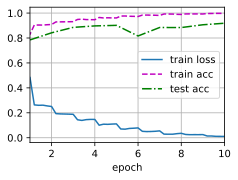

In [16]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.011, train acc 0.997, test acc 0.900
5854.9 examples/sec on cuda:0


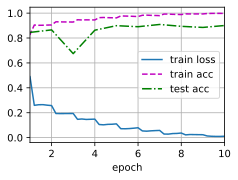

In [17]:
bm2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True, modified=True))
bm3 = nn.Sequential(*resnet_block(64, 128, 2, modified=True))
bm4 = nn.Sequential(*resnet_block(128, 256, 2, modified=True))
bm5 = nn.Sequential(*resnet_block(256, 512, 2, modified=True))
resnet_modified = nn.Sequential(b1, bm2, bm3, bm4, bm5, nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Flatten(), nn.Linear(512, 10))

lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [21]:
c1 = b1

In [22]:
def build_bottleneck(in_channels, hidden_channels, out_channels, num_layers):
    blk = []
    for i in range(num_layers):
        if i == 0:
            blk.append(BottleneckBlock(in_channels, hidden_channels, out_channels,
                                       use_1x1conv=True, stride=2))
        else:
            blk.append(BottleneckBlock(out_channels, hidden_channels, out_channels))
    return blk

In [23]:
c2 = nn.Sequential(*build_bottleneck(64, 64, 256, num_layers=3))
c3 = nn.Sequential(*build_bottleneck(256, 128, 512, num_layers=4))
c4 = nn.Sequential(*build_bottleneck(512, 256, 1024, num_layers=6))
c5 = nn.Sequential(*build_bottleneck(1024, 512, 2048, num_layers=3))

In [24]:
resnet50 = nn.Sequential(c1, c2, c3, c4, c5, nn.AdaptiveAvgPool2d((1, 1)),
                         nn.Flatten(), nn.Linear(2048, 10))

In [28]:
X = torch.rand(size=(1, 1, 224, 224)).to('cuda')
resnet50.cuda()
for layer in resnet50:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t',
          X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 1024, 7, 7])
Sequential output shape:	 torch.Size([1, 2048, 4, 4])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 2048, 1, 1])
Flatten output shape:	 torch.Size([1, 2048])
Linear output shape:	 torch.Size([1, 10])


loss 0.096, train acc 0.964, test acc 0.894
2960.6 examples/sec on cuda:0


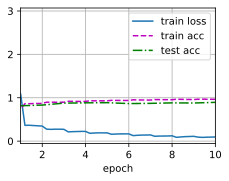

In [29]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(resnet50, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())